Installation & Import

In [1]:
!pip install gretel-synthetics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gretel-synthetics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import json
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.dates as md

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

from glob import glob
from datetime import timedelta

### Dataset

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ln -s /content/drive/MyDrive /mydrive

In [5]:
# Copy datasets from /mydrive to /content
!cd /mydrive/mushroom_dataset; cp TL5_shiitake.zip /content; cp VL5_shiitake.zip /content

In [6]:
# Unzip files
!mkdir /content/TL5; unzip TL5_shiitake.zip -d /content/TL5
!mkdir /content/VL5; unzip VL5_shiitake.zip -d /content/VL5

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/VL5/병해/표고_생육실1_3_18578610.json  
  inflating: /content/VL5/병해/표고_생육실1_12_18574995.json  
  inflating: /content/VL5/병해/표고_생육실1_3_18587030.json  
  inflating: /content/VL5/병해/표고_생육실1_2_18574680.json  
  inflating: /content/VL5/병해/표고_생육실1_3_18578515.json  
  inflating: /content/VL5/병해/표고_생육실1_10_18578190.json  
  inflating: /content/VL5/병해/표고_생육실1_8_18586456.json  
  inflating: /content/VL5/병해/표고_생육실1_2_18575443.json  
  inflating: /content/VL5/병해/표고_생육실1_7_18575278.json  
  inflating: /content/VL5/병해/표고_생육실1_1_18583868.json  
  inflating: /content/VL5/병해/표고_생육실1_2_18579567.json  
  inflating: /content/VL5/병해/표고_생육실1_10_18586793.json  
  inflating: /content/VL5/병해/표고_생육실1_1_18583762.json  
  inflating: /content/VL5/병해/표고_생육실1_5_18585646.json  
  inflating: /content/VL5/병해/표고_생육실1_4_18587745.json  
  inflating: /content/VL5/병해/표고_생육실1_5_18582436.json  
  inflating: /content/VL5/병해/표고_생육실1_12_18577496.json  
  inflating: /content/VL5

In [7]:
# GENERATE METADATA
def make_meta(json_dir):
  metadata = []

  for json_file in json_dir:
    with open(json_file) as file:
      anno_data = json.load(file)

    meta = anno_data['META']
    metadata.append(meta)

  metadata = pd.DataFrame.from_dict(metadata)
  metadata.index = json_dir

  return metadata

### Real data

In [8]:
dir_list = sorted(glob('/content/TL5/생육/*.json'))

# METADATA
meta_df = make_meta(dir_list)
meta_df = meta_df.sort_values(by=['IMAGE_CREATE_DATE', 'IMAGE_CREATE_TIME'])

# 'IP_CAMERA_ID'=1
meta_df_cam1 = meta_df[meta_df['IP_CAMERA_ID'] == 1]
meta_df_cam1['IMAGE_CREATE_TIME'] = pd.to_datetime(meta_df_cam1['IMAGE_CREATE_TIME']).dt.time
meta_df_cam1['IMAGE_CREATE_TIME'] = meta_df_cam1["IMAGE_CREATE_TIME"].apply(lambda x: x.strftime('%H:%M'))
cols = ['IMAGE_CREATE_DATE', 'IMAGE_CREATE_TIME', 'TEMPERATURE', 'HUMIDITY', 'CARBON_DIOXIDE']
meta_df_cam1 = meta_df_cam1[cols]

# 'IMAGE_CREATE_DATE'= '2021-10-26'~'2021-11-07'(11 DAYS)
# DIFFERENCE OF TIME IS 20 MIN
meta_df_cam1 = meta_df_cam1[(meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-10-26') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-10-27') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-10-29') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-10-30') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-10-31') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-01') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-02') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-03') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-05') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-06') |
                            (meta_df_cam1['IMAGE_CREATE_DATE'] == '2021-11-07')]

real_data = meta_df_cam1.drop(columns=['IMAGE_CREATE_DATE', 'IMAGE_CREATE_TIME']).to_numpy()
real_data = real_data.reshape(-1, 72, real_data.shape[1])
print(real_data.shape)

(11, 72, 3)


<ipython-input-8-44e599cff1ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_cam1['IMAGE_CREATE_TIME'] = pd.to_datetime(meta_df_cam1['IMAGE_CREATE_TIME']).dt.time
<ipython-input-8-44e599cff1ce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_cam1['IMAGE_CREATE_TIME'] = meta_df_cam1["IMAGE_CREATE_TIME"].apply(lambda x: x.strftime('%H:%M'))


### Load DGAN model

In [9]:
synthesizer_dgan = DGAN.load(file_name='/mydrive/Colab Notebooks/mushroom/model_param/dgan/synthesizer_dgan.pkl')

### Synthetic data

In [10]:
_, synthetic_data = synthesizer_dgan.generate_numpy(real_data.shape[0])
print(synthetic_data.shape)

(11, 72, 3)


### Descriptive statistics: real vs synth

In [11]:
real = real_data.reshape(-1, real_data.shape[-1])
real_df = pd.DataFrame(real, columns=['TEMPERATURE', 'HUMIDITY', 'CARBON_DIOXIDE'])

synth = synthetic_data.reshape(-1, real_data.shape[-1])
synth_df = pd.DataFrame(synth, columns=['TEMPERATURE', 'HUMIDITY', 'CARBON_DIOXIDE'])

print(real_df.describe())
print('')
print(synth_df.describe())

       TEMPERATURE    HUMIDITY  CARBON_DIOXIDE
count   792.000000  792.000000      792.000000
mean     17.022854   69.474495      592.091162
std       1.957480    4.414922       23.313408
min      14.200000   58.600000      529.300000
25%      15.500000   65.500000      576.900000
50%      16.300000   69.000000      591.500000
75%      18.600000   72.700000      608.000000
max      22.700000   83.300000      637.300000

       TEMPERATURE    HUMIDITY  CARBON_DIOXIDE
count   792.000000  792.000000      792.000000
mean     17.028034   69.196838      589.276978
std       1.912226    3.669274       23.621868
min      14.441448   61.959286      540.614441
25%      15.445615   66.416889      575.201721
50%      16.344326   68.853394      591.981415
75%      18.646311   71.331297      608.048676
max      21.453295   81.497421      633.569336


### Compare sample plot: real vs synth

In [12]:
# Show a few of the 1-day training samples
xaxis_1day = meta_df_cam1["IMAGE_CREATE_TIME"][0:72]
xticks = [xaxis_1day[i] for i in range(len(xaxis_1day)) if i%3 == 0]

def plot_day(real, synth):
  columns = ['TEMPERATURE', 'HUMIDITY', 'CARBON_DIOXIDE']
  obs = np.random.randint(len(real))

  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
  axs = axs.ravel(order='C')
  for i, c in enumerate(columns):
    axs[i].plot(xaxis_1day, real[obs][:,i], label='real', color='orange', linestyle='-')
    axs[i].plot(xaxis_1day, synth[obs][:,i], label='synth', color='blue', linestyle='--')
    axs[i].legend()
    axs[i].set_xticks(xticks)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(c)
  plt.tight_layout()
  plt.show()

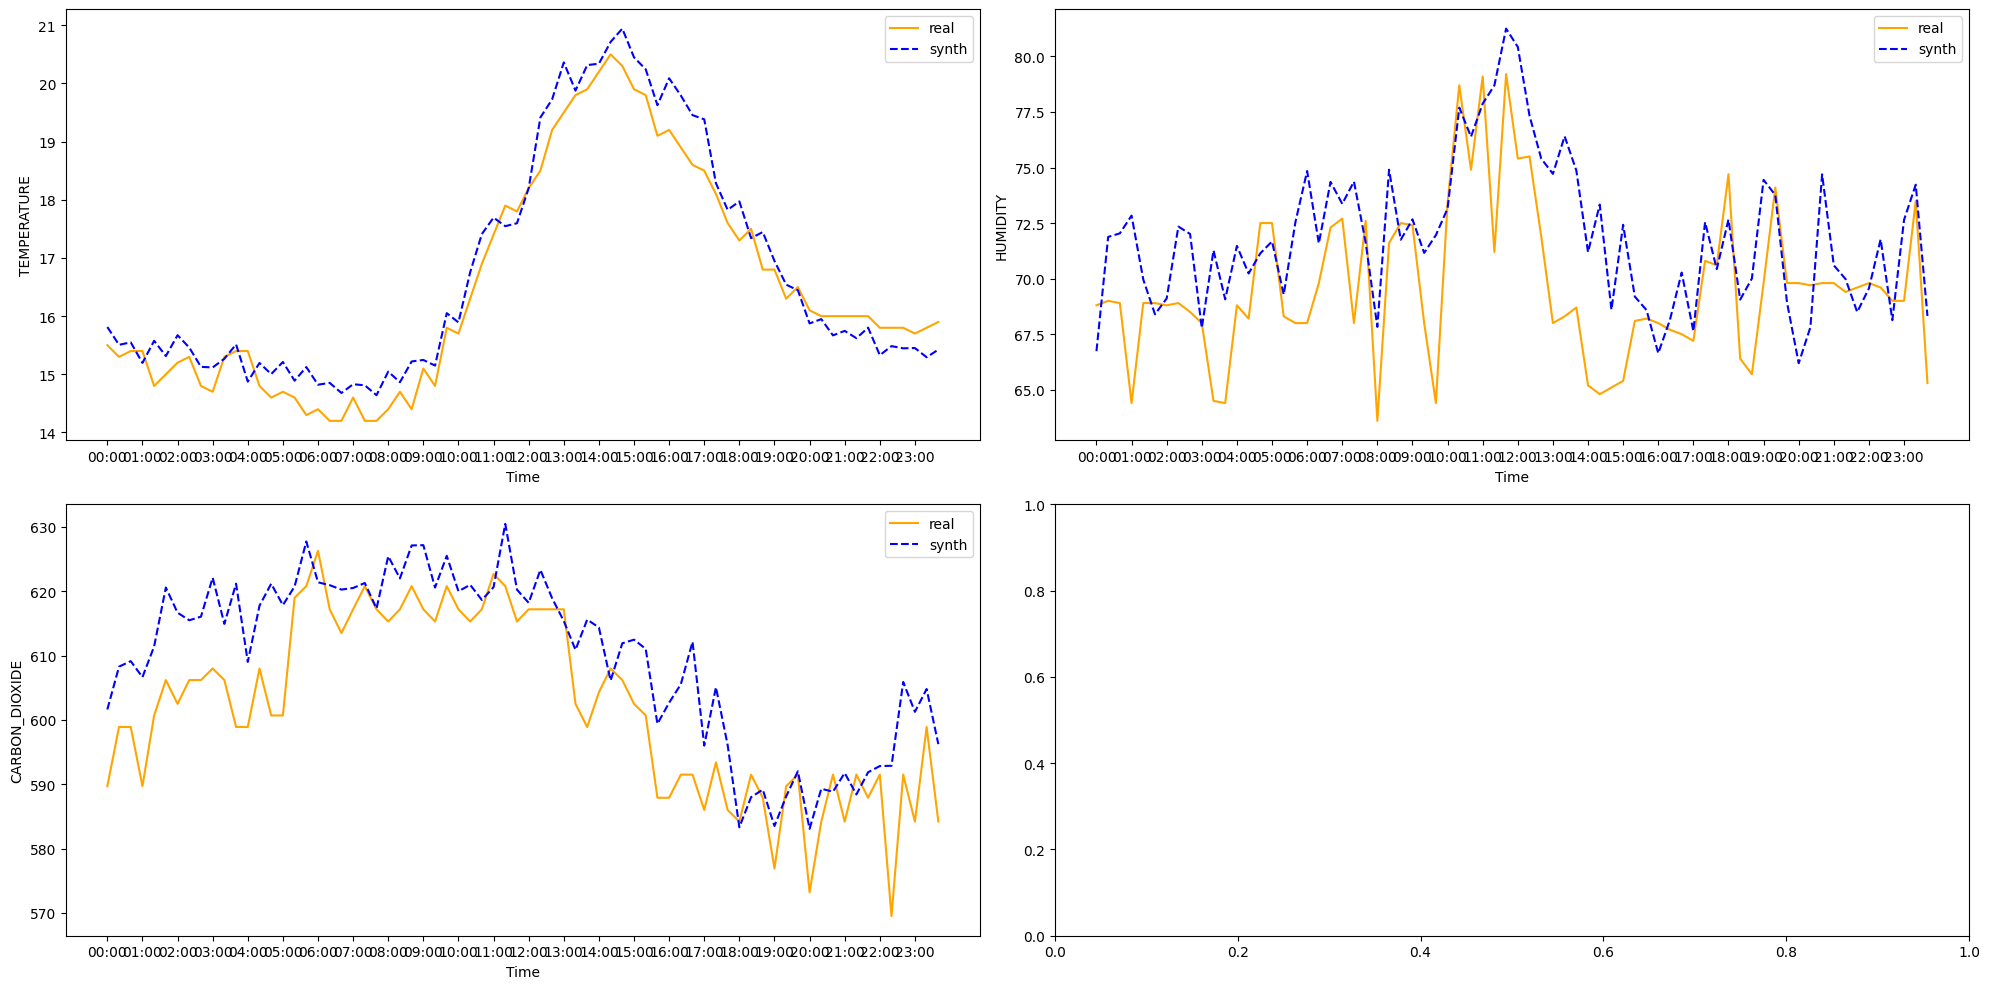

In [13]:
plot_day(real_data, synthetic_data)

### Box plot: real vs synth

In [14]:
def boxplot(real_df, synth_df, col):
  fig, ax = plt.subplots()
  ax.boxplot([real_df[col], synth_df[col]])
  plt.title('real vs synth')
  plt.xticks([1,2], [f'real_{col}', f'synth_{col}'])
  plt.show()

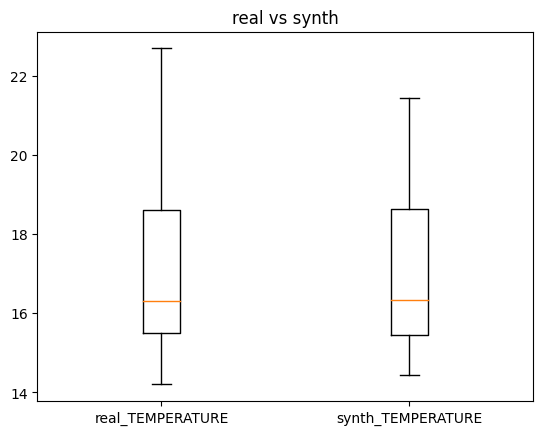

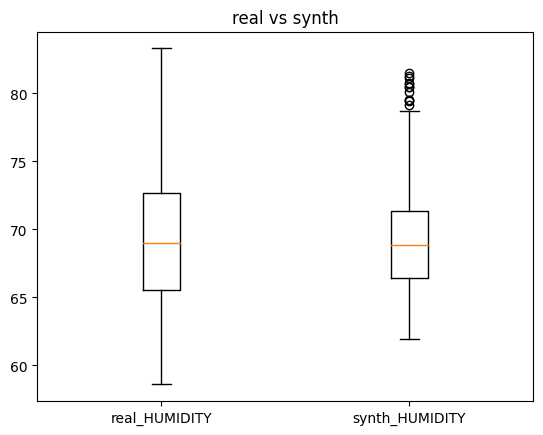

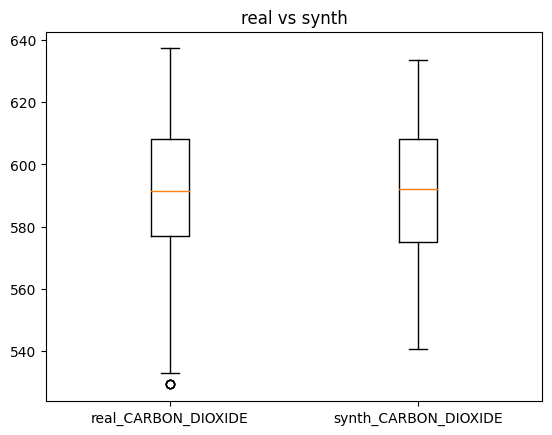

In [15]:
boxplot(real_df, synth_df, 'TEMPERATURE')
boxplot(real_df, synth_df, 'HUMIDITY')
boxplot(real_df, synth_df, 'CARBON_DIOXIDE')

### PCA & TSNE

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seq_len = 24
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

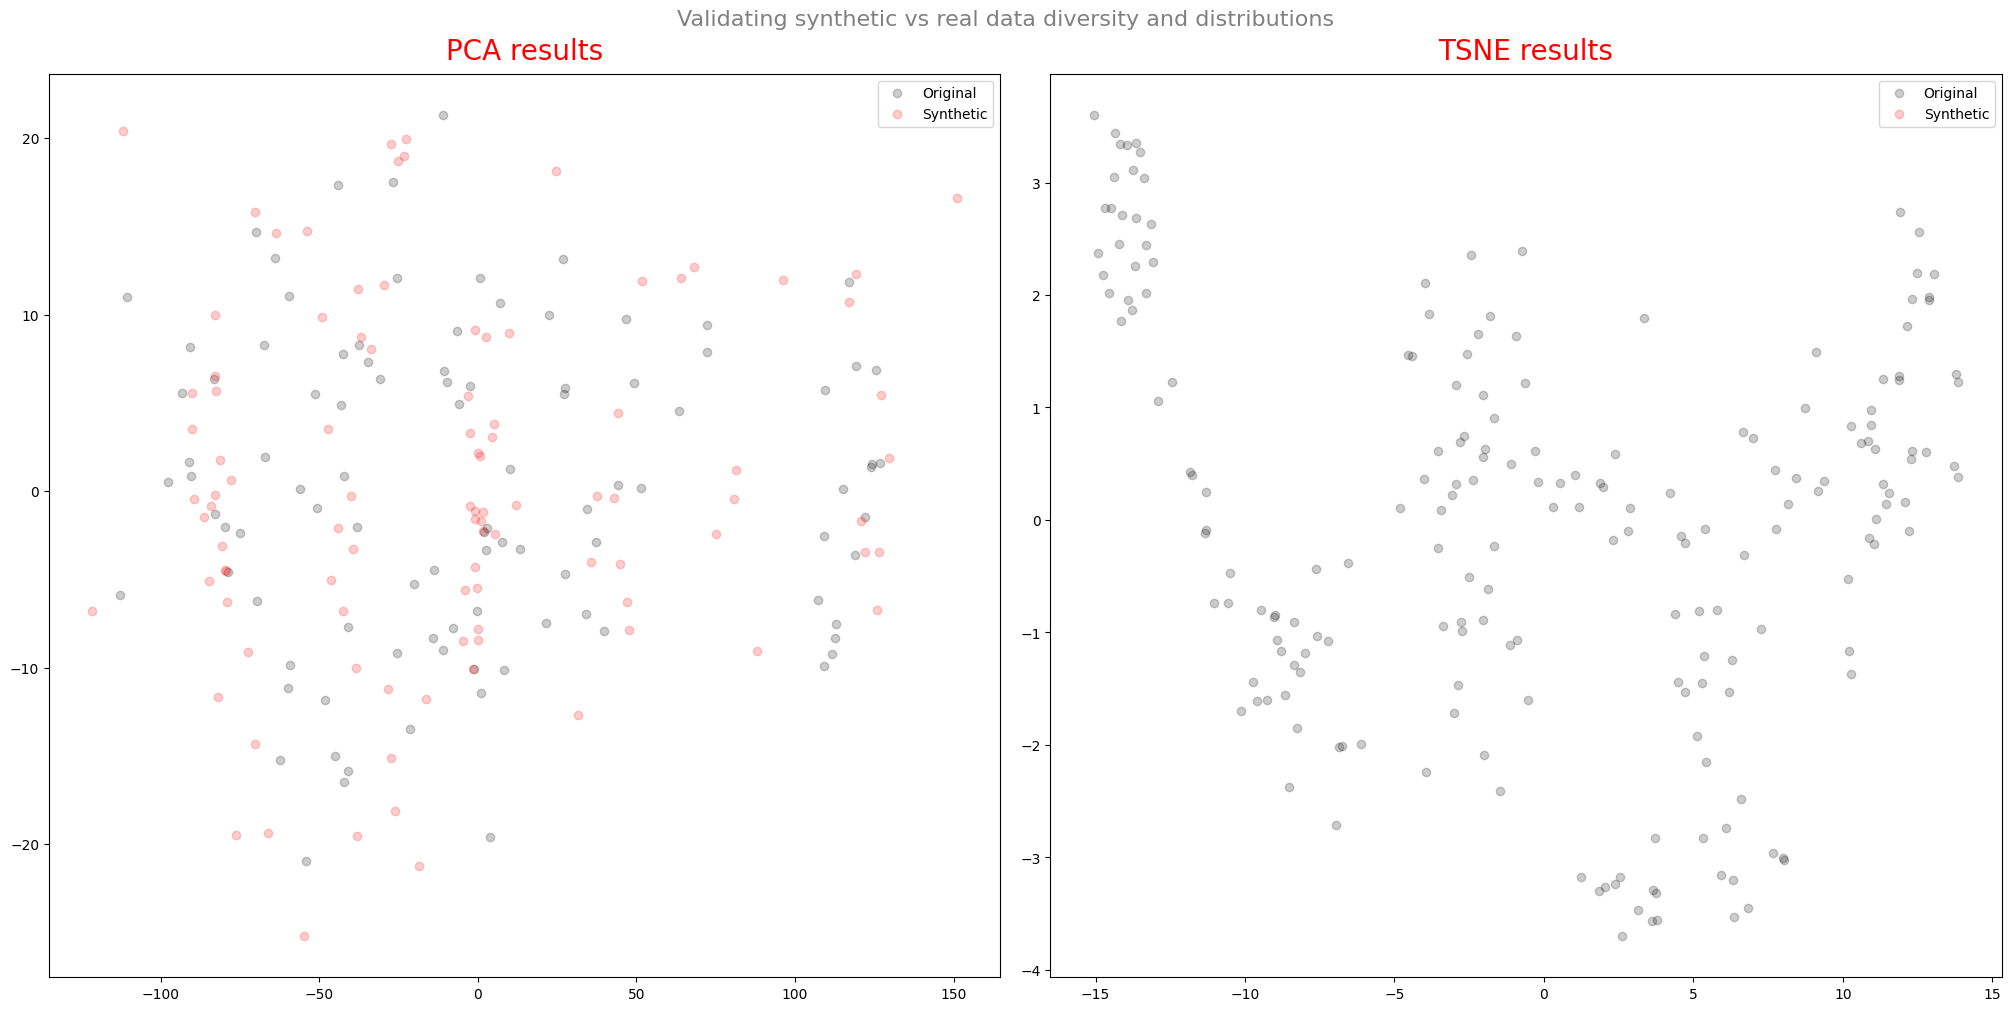

In [17]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')